# ☀ Analysis of Brisbane Photovoltaic Installation Data ☀


## Introduction

For this excerise I will take open data on demographic profiles of various suburbs around Brisbane to answer four questions relating to a problem statement. 
The problem statement is:
> Our customer wishes to use this data to understand possible demand for solar panel installations when entering a new region, where counts of installations will not be available but the other factors will be present. This will allow them to focus advertising on suburbs where they are most likely to have a high demand.

The questions are:
1. Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.
2. Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.
3. Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.
4. Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.

I will include a preamble to each question that tries to explain my approach and then I will follow it with analysis and finally by a conclusion and answer.

---

## Import packages and data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import re

In [2]:
# Read in data file to dataframe
df = pd.read_excel('Brisbane Suburbs Stats Separated V2.0.xlsx')

---
## Question 1

> Please provide a summary and analysis of the factors that you determine to be important for the prediction of the likely number of installations.

For starters I'll derive some extra columns. In particular, we can find the total population in 2017 by summing across the age columns.

My first thought is that we should consider predicting both `'Small-scale solar panel system installations (no.) 2017'` and this relative to the suburb's total population, `'Solar installations per capita (2017)'`. 

One problem predicting the first variable is that it could be highly correlated with the population of the suburb and modelling this quantity could just pick out characteristics that correlate with high population. One problem with predicting the second variable is that we could ignore important sales benefits that come with high population.

By accounting for both we could find a middle ground that solves this problem more generally.

In [3]:
# Derive some extra columns

# Some extra time series data
# I'm doing this first and in different for loops to make sure the time series stuff all appears in one group and in order of category
for year in range(2002, 2019):
    df[f'Avg new house value {year}'] = df[f'BA Value of new houses {year}']/df[f'BA New houses {year}']
for year in range(2002, 2019):
    df[f'Avg alts & adds {year}'] = (df[f'BA Value of alts & adds to residential building {year}']/df[f'BA Total dwellings {year}'])

# Some other columns that could be helpful
df['Total Population (2017)'] = df[df.columns[5:23]].sum(axis=1)  # I've assumed the age columns capture everyone living in a given suburb
df['Approx km2'] = df['Total Population (2017)']/df['Population density (ERP at 30 June) (persons/km2) 2018']  # Here I've assumed the population has not changed much between 2017 and 2018
df['Solar installations per capita (2017)'] = df['Small-scale solar panel system installations (no.) 2017']/df['Total Population (2017)']

# Replace infinite values with NaNs so that they don't mess up averages, etc
df.replace([np.inf, -np.inf], np.nan,inplace=True)

In [4]:
# Isolate index and target columns
idx_col     = df.columns[2:3]  # I don't think I need Suburb or Postcode - Just use ABS code as index
target_cols = df.columns[101:102].union(['Solar installations per capita (2017)'])

### The first thing I'll do is find correlation between variables using Pearson and Spearman's correlation

This is a good way to get started since the correlation coefficients are invariant to normalisation.

Pearson's is pretty standard and a great way to discover clusters of dependent variables which can help understand importance of variables better. Spearman's is good because it's invariant under monotonically increasing functions (e.g. log or log/log transforms).

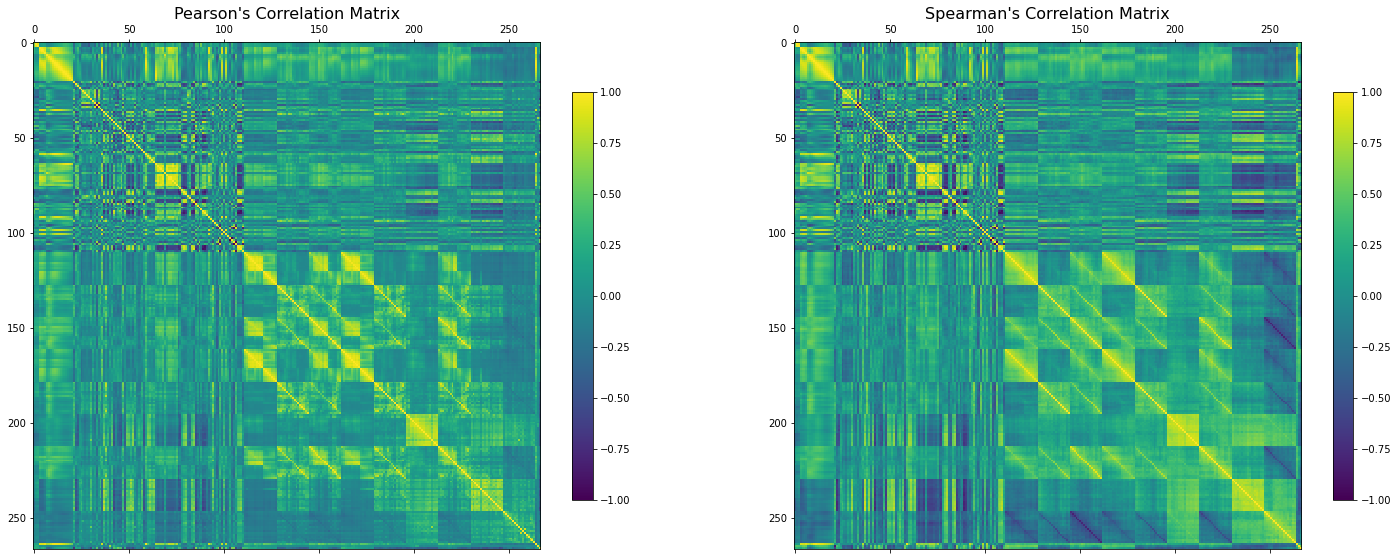

In [5]:
pearson_mat = df.corr(method='pearson')
spearman_mat = df.corr(method='spearman')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.matshow(pearson_mat, fignum=False)
plt.title("Pearson's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()

plt.subplot(1, 2, 2)
plt.matshow(spearman_mat, fignum=False)
plt.title("Spearman's Correlation Matrix", fontsize=16)

cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params()
plt.show()

There's a lot going on here due to the sheer number of columns, but we can definitely see plenty of dark blue and yellow indicating there is correlation to be found. The variables in the bottom right are from the time series data which is why they form blocks of high correlation. For simplicity's sake I will continue by just looking at the Spearman's correlation coeffiecients which will make the analysis simpler, but in general I might try to do something more complicated to incorporate both as they both have advantages and disadvantages.

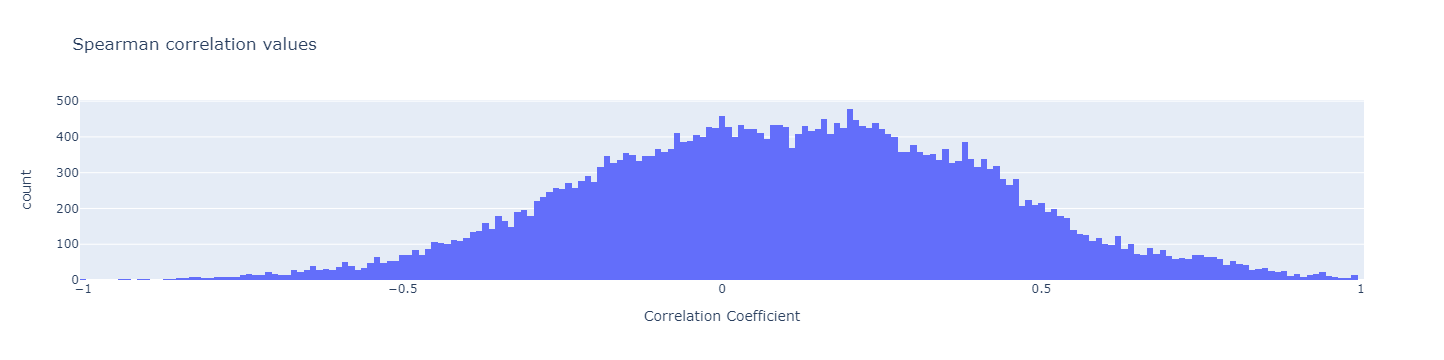

In [6]:
# Flatten correlation matrix
# Note: only need to count up to the ith element in each row since matrix is symmetric with 1s along the 
#       diagonal which we can exclude (as they offer no insight)
spearman_vals = [item for i, row in enumerate(spearman_mat.values.tolist()) for item in row[:i]]

fig = px.histogram(
    spearman_vals,
    title='Spearman correlation values',
    labels={'value':'Correlation Coefficient'}
)

fig.update_layout(showlegend=False)
fig.show()

This histogram shows the distribution of correlation between the columns in our dataset. It indicates that there are lots of dependencies between the columns which we will have to consider if we want to make sure we're modelling our target accurately. Since both high and low correlation will help us answer these questions from our dataset, let's plot a histogram absolute value of correlation coefficients for our target variables.

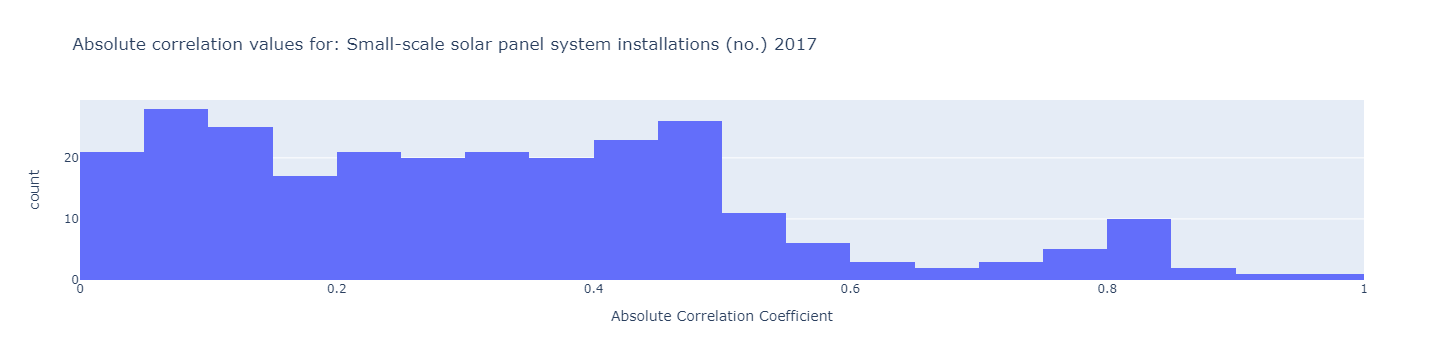

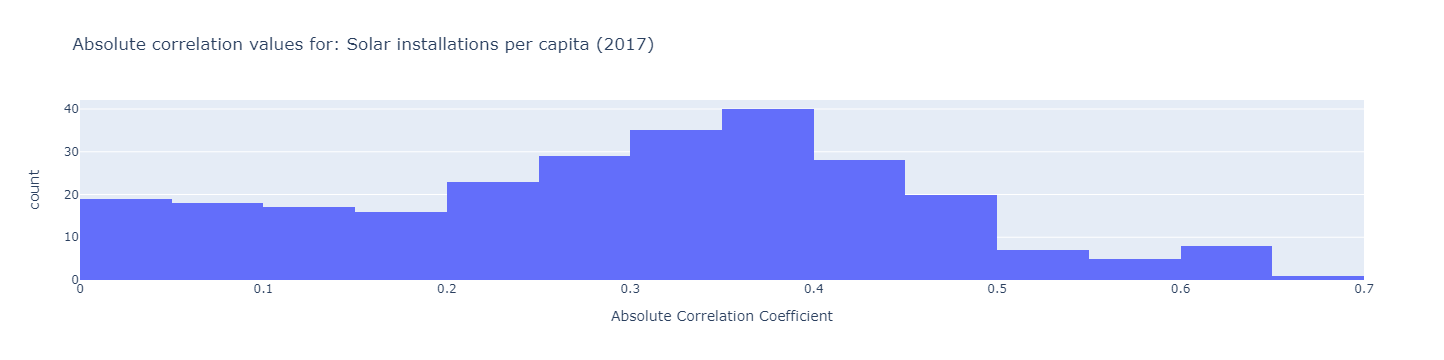

In [7]:
# Plot histograms of absolute values of correlation coefficients
for target_col in target_cols:
    fig = px.histogram(
        abs(spearman_mat[target_col].loc[[col for col in spearman_mat.index if col != target_col]]),
        title= f'Absolute correlation values for: {target_col}',
        labels={'value':'Absolute Correlation Coefficient'}
    )

    fig.update_layout(showlegend=False)
    fig.show()

This indicates that there are more variables in our dataset that correlate strongly with `'Small-scale solar panel system installations (no.) 2017'` than `'Solar installations per capita (2017)'`. Again, this could be because that `'Small-scale solar panel system installations (no.) 2017'` is a proxy for the total population size of the suburb.

In [8]:
print('Correlation between target columns and Total population:')
spearman_mat[target_cols.union(['Total Population (2017)'])].loc[target_cols.union(['Total Population (2017)'])]

Correlation between target columns and Total population:


Small-scale solar panel system installations (no.) 2017  \
Small-scale solar panel system installations (n...                                           1.000000         
Solar installations per capita (2017)                                                        0.639277         
Total Population (2017)                                                                      0.772637         

                                                    Solar installations per capita (2017)  \
Small-scale solar panel system installations (n...                               0.639277   
Solar installations per capita (2017)                                            1.000000   
Total Population (2017)                                                          0.089111   

                                                    Total Population (2017)  
Small-scale solar panel system installations (n...                 0.772637  
Solar installations per capita (2017)                              0.089111  
Total Population (2017)                                            1.000000

It will also help our analysis if we remove the column `'Solar water heater installations (no.) 2017'` before continuing.

As you can see below, it correlates very strongly with the targets:

In [9]:
print('Correlation between target columns and solar water heater installations:')
spearman_mat[target_cols.union(['Solar water heater installations (no.) 2017'])].loc[target_cols.union(['Solar water heater installations (no.) 2017'])]

Correlation between target columns and solar water heater installations:


Small-scale solar panel system installations (no.) 2017  \
Small-scale solar panel system installations (n...                                           1.000000         
Solar installations per capita (2017)                                                        0.639277         
Solar water heater installations (no.) 2017                                                  0.962002         

                                                    Solar installations per capita (2017)  \
Small-scale solar panel system installations (n...                               0.639277   
Solar installations per capita (2017)                                            1.000000   
Solar water heater installations (no.) 2017                                      0.599422   

                                                    Solar water heater installations (no.) 2017  
Small-scale solar panel system installations (n...                                     0.962002  
Solar installations per capita (2017)                                                  0.599422  
Solar water heater installations (no.) 2017                                            1.000000

Without further information, this variable could be peaking at the target (e.g. `'Solar water heater installations (no.) 2017'` < `'Solar water heater installations (no.) 2017'` for every suburb, so it could be that this number is a strict subset of the target). I'm choosing to remove it at this stage to make our analysis better below.

In [10]:
# Dropping Solar water heater installations column
spearman_mat = spearman_mat.drop('Solar water heater installations (no.) 2017', axis=0).drop('Solar water heater installations (no.) 2017', axis=1)

### Important variables
Let's draw out important columns for each of these targets using these coefficients. We'll set an arbitrary cutoff for correlation importance and then use those as a first cut for our features of importance.

In [11]:
correlation_cutoff = 0.4

In [12]:
# For each target_cols[i] there will be a list of features in target_features[i]
# It looks complicated, but it's just making sure the correlation with the target variable is above the cutoff and that it's also not the target column
target_features = [
    [feature for feature in spearman_mat[abs(spearman_mat[target_col]) > correlation_cutoff].index if feature not in target_cols] for i, target_col in enumerate(target_cols)
]

# These are features that are deemed important for all targets
important_features = spearman_mat[(abs(spearman_mat[target_cols]) > correlation_cutoff).all(axis=1)].index

How many variables are we keeping around if we restrict ourselves to variables of high importance?

In [13]:
print(f"There are {len(df)} total columns in our dataset (some of which I derived).")
for i, f in enumerate(target_features):
    print(f"There are {len(f)} features with absolute correlation > {correlation_cutoff} for target: {target_cols[i]}.")
print(f"There are {len(important_features)} features with absolute correlation > {correlation_cutoff} shared by ALL targets.")

There are 264 total columns in our dataset (some of which I derived).
There are 91 features with absolute correlation > 0.4 for target: Small-scale solar panel system installations (no.) 2017.
There are 67 features with absolute correlation > 0.4 for target: Solar installations per capita (2017).
There are 33 features with absolute correlation > 0.4 shared by ALL targets.


These could have interdependencies that make it bad for modelling, here is the correlation matrix restricted to columns that are very highly correlated with other variables in our dataset.

### Independence

I'm going to crudely remove dependent variables above a certain cutoff from each target features list based on another cutoff, prioritised by how strongly it correlates with the target variables. This could be done in a much more careful way, but it's not a terrible idea to quickly remove independence problems. If I wanted to take more care, I could try deriving some columns that capture the true relationship (e.g. create a column called `"Children population"` which is the sum of the population across 0-14 year olds).

In [14]:
# Set a dependence cut-off
dependence_cutoff = 0.8
target_features_independent = []

# Iterate over the different target features
for i, features in enumerate(target_features):
    independent_features = []
    
    # Iteratively check for dependence, then add to new feature list if it's below threshold
    for feature in abs(spearman_mat[target_cols[i]][features]).sort_values(ascending=False).index:
        if (spearman_mat[feature].loc[independent_features] > dependence_cutoff).any():
            pass
        else:
            independent_features.append(feature)
    
    target_features_independent.append(independent_features)

for i, f in enumerate(target_features_independent):
    print(f"There are now {len(f)} features deemed to be independent for target: {target_cols[i]}.")
    lf = '\n\t* '.join(f[:20])
    print(f"The top 20 are:\n\t* {lf}")
    print()

There are now 39 features deemed to be independent for target: Small-scale solar panel system installations (no.) 2017.
The top 20 are:
	* Separate house (no.) 2016
	* Persons - 60-64 years (no.) 2017
	* Family Tax Benefit A (no.) 2018
	* Persons - 35-39 years (no.) 2017
	* Approx km2
	* BA New houses 2002
	* BA New houses 2008
	* Persons - 80-84 years (no.) 2017
	* Disability Support Pension (no.) 2018
	* BA New houses 2006
	* BA New houses 2004
	* Retail trade (%) 2016
	* Attached Dwellings - median sale price ($) 2016
	* Technicians and trades workers (%) 2016
	* BA New houses 2017
	* Professionals (%) 2016
	* Persons over 15 earning $500-$999 per week (%) 2016
	* BA New houses 2012
	* Avg alts & adds 2008
	* Households with mortgage repayments greater than or equal to 30% of household income (%) 2016

There are now 45 features deemed to be independent for target: Solar installations per capita (2017).
The top 20 are:
	* Rented (%) 2016
	* Households with mortgage repayments greater

### Let's quickly run a random forest regressor to see if how it ranks features importance

First we'll find feature importance using a random forest for and while we're at it, compare it to if we'd just used all the variables apart from the target variables.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# We'll impute NaN values with the mean to make sure this can run
df_train = df.fillna(df.mean(numeric_only=True))

# A naive choice of X with all columns
X_train, X_test, y_train, y_test = train_test_split(
    df_train[[col for col in df_train.columns[3:] if col not in target_cols]],
    df_train[target_cols],
    random_state=42
)

Feature importance after finding independent variables for Small-scale solar panel system installations (no.) 2017:


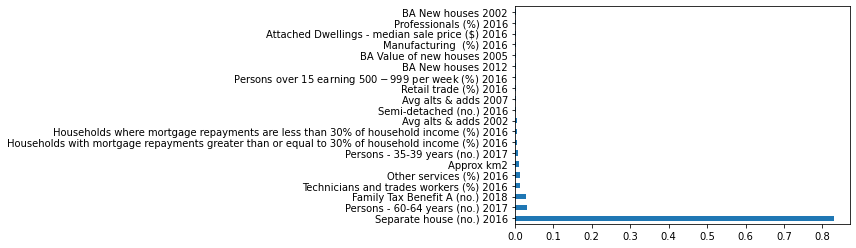

Model score on training data: 0.9855579465925165
Model score on testing data: 0.9022095952870378
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Naive Feature importance with all variables for Small-scale solar panel system installations (no.) 2017:


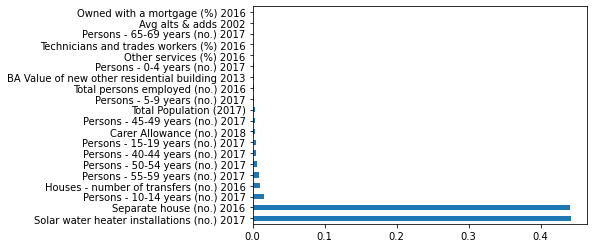

Niave model score on training data: 0.9907526528003039
Niave model score on testing data: 0.9190256955832478
Feature importance after finding independent variables for Solar installations per capita (2017):


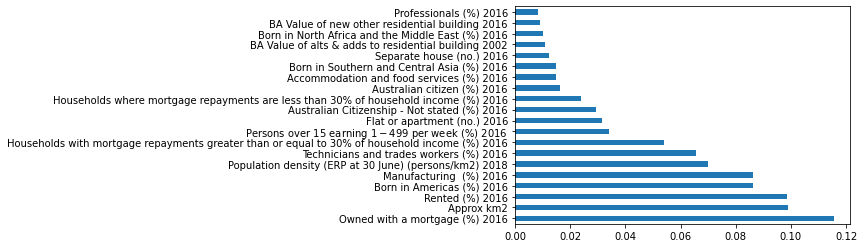

Model score on training data: 0.9668118925095076
Model score on testing data: 0.6403531731650711
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Naive Feature importance with all variables for Solar installations per capita (2017):


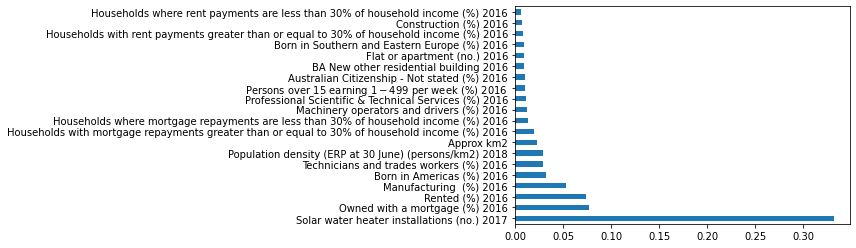

Niave model score on training data: 0.9673290260914256
Niave model score on testing data: 0.6433558735620909


In [16]:
for i, features in enumerate(target_features_independent):
    print(f"Feature importance after finding independent variables for {target_cols[i]}:")
    Xi = X_train[features]
    yi = y_train[target_cols[i]]
    
    model = RandomForestRegressor()
    model.fit(Xi,yi)
    
    # Calculate feature importances and plot the largest 20
    feat_importances = pd.Series(model.feature_importances_, index=Xi.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    
    print(f'Model score on training data: {model.score(Xi, yi)}')
    print(f'Model score on testing data: {model.score(X_test[features], y_test[target_cols[i]])}')
    print('- '*100)
    print(f"Naive Feature importance with all variables for {target_cols[i]}:")
    # Now compare to fitting against all columns
    n_model = RandomForestRegressor()
    n_model.fit(X_train,yi)
    
    # Calculate feature importances and plot the largest 20
    feat_importances = pd.Series(n_model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    plt.show()
    
    print(f'Niave model score on training data: {n_model.score(X_train, yi)}')
    print(f'Niave model score on testing data: {n_model.score(X_test, y_test[target_cols[i]])}')
    
    print("="*200)

### Conclusion

After doing some simple correlation coefficient analysis and reframing the question in terms of a second target variable we have a reasonable looking list of factors that could be used for modelling demand in . We were also able to identify some factors that seemed to correlate to strongly with the target and had reasonable predictive power. Note that we get better performance for the solar installations per capita with the restricted columns, which could probably be improved much further with more care and hyper-parameter tuning.

In the analysis notebook, I attempted to utilise the BA time series to derive some features, but I didn't have the time to get very far. I was interested in trying to cluster suburbs based upon their position relative to the median, or calculate the "derivative" (e.g. first differeneces). I think there could be some interesting insights in that data which is not used to its full potential here.

It should also be noted that further ethical analysis should be undertaken since ethnicity data is highly correlated with the second target variable.

---

## Question 2

> Please give a description of any surprising findings or spurious factors that you believe may generalize poorly to new regions.

The first problematic correlation I found was between solar panel installations and solar water heaters installations. 

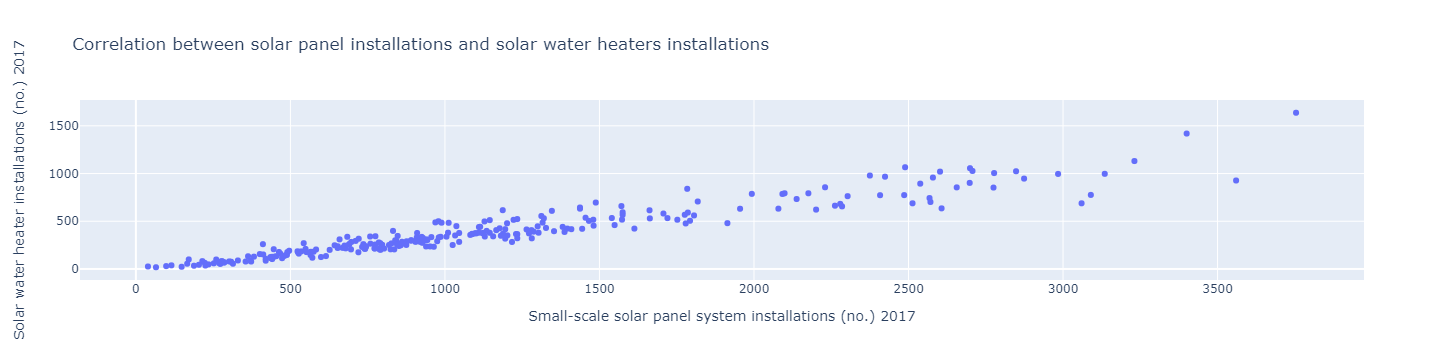

In [17]:
# Check how closely solar panels and solar water heaters are correlated
fig = px.scatter(
    df, 
    x="Small-scale solar panel system installations (no.) 2017", y="Solar water heater installations (no.) 2017",
    title= f'Correlation between solar panel installations and solar water heaters installations'
)
fig.show()

I suspect there is some variable peaking happening here if we used it to model either target variable. Without having more information, this could potentially be because solar water heaters installations are reported as a proper subset of solar panel installations. Spurious or not, it certainly wouldn't generalise to new regions where this value would be zero.

One surprising relationship was how strongly `'Separate house (no.) 2016'` correlates with `"Small-scale solar panel system installations (no.) 2017"`. It's hard to think why this would be such a strong relationship (The ABS defines it as 'a house which is separated from other dwellings by a space of at least half a metre.' ... 'such as a granny flat or converted garage') and I would tend to treat it with suspicion.

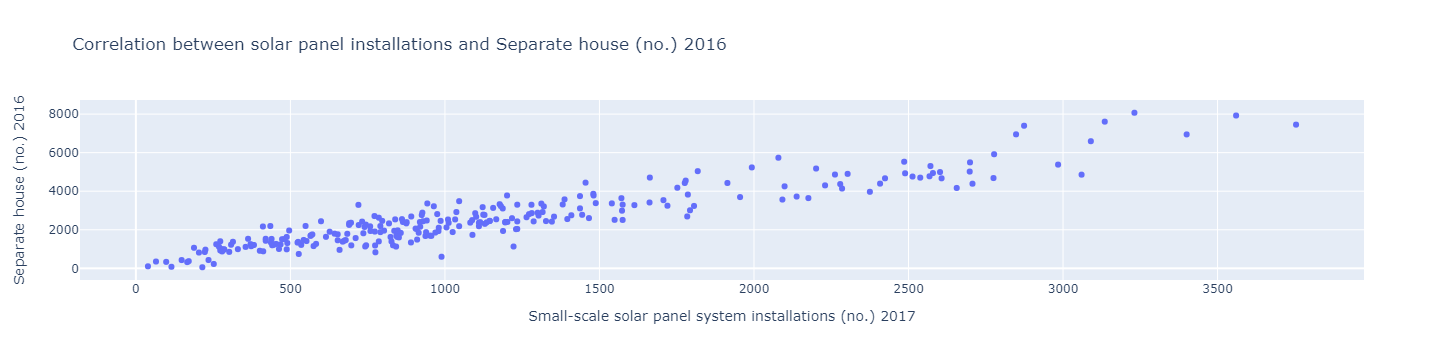

In [18]:
# Check how closely solar panels and solar water heaters are correlated
fig = px.scatter(
    df, 
    x="Small-scale solar panel system installations (no.) 2017", y="Separate house (no.) 2016",
    title= f'Correlation between solar panel installations and Separate house (no.) 2016'
)
fig.show()

While exploring the data, I also found it surprising how often `"Increase in installations from previous year (%) 2017"` and `"Small-scale solar panel system installations (no.) 2017"` had opposite correlations to one another while analysing other factors (183 out of the 264 total variables).

In [19]:
c = ["Increase in installations from previous year (%) 2017", "Small-scale solar panel system installations (no.) 2017"]
spearman_mat[spearman_mat[c[0]]*spearman_mat[c[1]]<0][c]

Increase in installations from previous year (%) 2017  \
Persons - 0-4 years (no.) 2017                                                 -0.184263       
Persons - 5-9 years (no.) 2017                                                 -0.177959       
Persons - 10-14 years (no.) 2017                                               -0.172202       
Persons - 15-19 years (no.) 2017                                               -0.143997       
Persons - 30-34 years (no.) 2017                                               -0.009951       
...                                                                                  ...       
Avg alts & adds 2017                                                            0.065328       
Avg alts & adds 2018                                                            0.108178       
Total Population (2017)                                                        -0.090872       
Approx km2                                                                     -0.080155       
Solar installations per capita (2017)                                          -0.304092       

                                       Small-scale solar panel system installations (no.) 2017  
Persons - 0-4 years (no.) 2017                                                  0.797113        
Persons - 5-9 years (no.) 2017                                                  0.866717        
Persons - 10-14 years (no.) 2017                                                0.875746        
Persons - 15-19 years (no.) 2017                                                0.828317        
Persons - 30-34 years (no.) 2017                                                0.467056        
...                                                                                  ...        
Avg alts & adds 2017                                                           -0.246756        
Avg alts & adds 2018                                                           -0.304311        
Total Population (2017)                                                         0.772637        
Approx km2                                                                      0.641260        
Solar installations per capita (2017)                                           0.639277        

[183 rows x 2 columns]

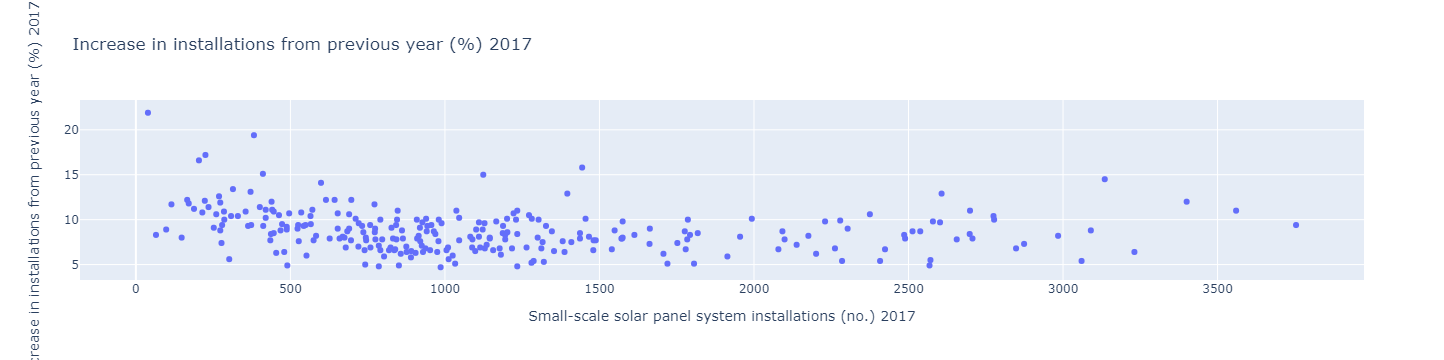

In [20]:
# Check how closely solar panels and solar water heaters are correlated
fig = px.scatter(
    df, 
    x="Small-scale solar panel system installations (no.) 2017", y="Increase in installations from previous year (%) 2017",
    title= "Increase in installations from previous year (%) 2017"
)
fig.show()

It seemed counter-intuitive to me that a percentage increase in installations from the previous year would negatively correlate with total installation and plotting them against each other doesn't reveal much. It could be that there is no real correlation, but that a higher percentage increase is more likely in areas with low numbers of customers (i.e. a smaller denominator in the percentage calculation) which causes a false linear correlation coefficient.

It's also interesting to note that when you consider the `'Solar installations per capita (2017)'` column I derived, you get far more demographic features pop out as important. I think this indicates it would generalise better to other suburbs, since the column `'Small-scale solar panel system installations (no.) 2017'` is a count and therefore very tied to the number of people living in that suburb.

It should also be noted that ethnicity was deemed a factor of importance when analysing the correlation coefficients as well as the simple random forest regression. Ethical analysis should be undertaken to ensure that modelling did not unduly cause racism.

---

## Question 3

> Please provide any caveats (or “gotchas”) that you believe may undermine the power of any predictive model developed from these factors.

The first caveat I would give would be that much more work could be done to derive useful columns/aggregates and tune the hyper-parameters used to find the important factors (e.g. choosing the correlation thresholds). There are still clearly problematic relationships that should be explored more as I've illustrated in the previous question.

I think modelling the column I derived, `'Solar installations per capita (2017)'`, makes more sense for the problem statement despite the exercise nudging you towards modelling `'Small-scale solar panel system installations (no.) 2017'` however both have their merits. I would be concerned that a model trained to predict `'Small-scale solar panel system installations (no.) 2017'` would minimise its error by overly weighting other columns correlated with total population size and then not make insightful predictions that generalise beyond the size of the suburb. More testing would need to be done to properly understand how to best solve this problem, and it could still be the correct choice of target. In fact, both of these columns could be the incorrect choice and it may be worth completing a longer exploration into finding the most suitable target.

Another caveat is that many of the columns in this dataset have dependencies (which I've explored a little more in the other scratch notebook) which should be well understood. I have tried with some crude methods to enforce more independence between the factors I've chosen, but we could go much further to understand the interdependencies.

---

## Question 4

> Please outline any data you would wish to augment this dataset with to make a more powerful predictive model or any experiments you would propose to rule out spurious correlations.


In general, it would be good to get more time points for all of the columns so that we have a better understanding of the role time plays, especially for the target variable. Also being able to validate these relationships outside of Brisbane would be interesting, so more spatial data would be good too.

Some interesting data sets that could lead to a more predictive model:

*Financial data:*
* Electricity prices
* ASX data (e.g. XAO)
* Average wages by industry
* Average wages by ethnicity (so that we could do proper ethical analysis about why ethnicity was a factor)
* Distance to customer as a 2D vector

*Demographic data:*
* Election results
* Gender data

*Geographical data:*
* Weather (Would be interesting to compare with other suburbs in other cities)
* Altitude


Some experiments I would do to rule out spurious correlations
* Derive columns that capture dependencies to see if it simplifies model
    - e.g. derive a `'Total Children'` column which could be the sum of 0-14 year olds, that way we incorporate their affect on the target without worrying about dependence
* Dig deeper into why `'Separate house (no.) 2016'` is so strongly correlated with `'Small-scale solar panel system installations (no.) 2017'`
* Perform Monte Carlo feature selection to determine whether the features are robust or sensitive to change
* Cluster suburbs based on BA time series data to derive extra columns

---